In [23]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle
from scipy.signal import argrelextrema,argrelmin, argrelmax
from itertools import combinations


import sys, os
sys.path.append(os.path.abspath('..'))
from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 1 

mpl.rcParams.update({'font.size': 10, 'lines.linewidth': 1, 'figure.dpi': 100})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

In [ ]:
import nest_asyncio
nest_asyncio.apply()

## Load the candlesticks

In [281]:
pair = 'BTC_USDT'
timeframe = '8h'

exchange = 'binance'
def load_candles(exchange, pair, timeframe):
    odf = pd.read_json(f'../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
    # exchange = 'kucoin'
    # odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
    ).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
    ).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
    ).set_index('dtime').sort_index()
    return odf

# print(odf.shape)
# odf.head(4)

### Add some stuff

In [287]:
odf = load_candles(exchange, pair, timeframe)
emas = [7, 14, 21, 26, 50, 120, 240]

odf = odf.join(pd.DataFrame({
        k:v for k,v in [
        ('ohl3', (odf.open + odf.high + odf.low) / 3),
        ('iord', range(odf.shape[0])),
        ('lret', odf.close.divide(odf.open).apply(np.log)),
        ('bo_low', odf[['open', 'close']].min(axis=1)),
        ('bo_high', odf[['open', 'close']].max(axis=1)),
        ('ca_range', odf.high.divide(odf.low).apply(np.log)),
        ('ca_dir', 1 - 2 * (odf.close < odf.open).astype(int)),
        ]
    }))
odf = odf.join(pd.DataFrame({
        k:v for k,v in [
        ('bo_range', odf.bo_high.divide(odf.bo_low).apply(np.log)),
        ('ca_wickD', odf.low.divide(odf.bo_low).apply(np.log)),
        ('ca_wickH', odf.high.divide(odf.bo_high).apply(np.log)),
        ]
    }))
odf = odf.join(pd.DataFrame({  k:v 
    for lag in range(1,7)
    for col in ['lret', 'bo_low', 'bo_high', 'bo_range', 'ca_range', 'ca_wickD', 'ca_wickH']
    for k,v in [
        [f'la_{lag}_{col}' , odf[col].shift(lag).bfill()]
    ]}))

odf = odf.join(pd.DataFrame({
    k:v 
    for e in emas
    for k,v in [
        (f'ema_{e}' , odf.close.ewm(e).mean()),
        (f'ewstd_{e}' , odf.close.ewm(e).std()),
    ]
}))
odf = odf.join(pd.DataFrame({
    k:v 
    for e in emas
    for k,v in [
        (f'c_ema_ret_{e}' , (odf.close / odf[f'ema_{e}']).apply(np.log)),
    ]
}))

odf = odf.join(pd.DataFrame({
        k:v 
        for e in combinations(emas, 2)
        for k,v in [(f'ema_ret_{e[0]}_{e[1]}' , np.log(padf[f'ema_{e[0]}'] / padf[f'ema_{e[1]}']))]
    })
)

# padf
mzn_res = call_mzn_model('last-such', {'markers': odf.ca_dir.values.tolist()})
# odf = odf.join(padf).assign(n_prev=mzn_res['prev'])
odf['n_prev'] = mzn_res['prev']
odf.head(5)

,timestamp,open,high,low,close,volume,ohl3,iord,lret,bo_low,...,ema_ret_21_50,ema_ret_21_120,ema_ret_21_240,ema_ret_26_50,ema_ret_26_120,ema_ret_26_240,ema_ret_50_120,ema_ret_50_240,ema_ret_120_240,n_prev
dtime,,,,,,,,,,,,,,,,,,,,,
2017-08-17 00:00:00,1502928000000,4261.48,4349.99,4261.32,4349.99,82.088865,4290.930000,0,0.020557,4261.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2017-08-17 08:00:00,1502956800000,4333.32,4485.39,4333.32,4352.34,238.181883,4384.010000,1,0.004380,4333.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2017-08-17 16:00:00,1502985600000,4352.33,4369.69,4200.74,4285.08,474.879629,4307.586667,2,-0.015572,4285.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2017-08-18 00:00:00,1503014400000,4285.08,4340.62,4134.61,4300.25,524.582072,4253.436667,3,0.003534,4285.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2017-08-18 08:00:00,1503043200000,4285.00,4371.52,4193.70,4236.89,372.109513,4283.406667,4,-0.011291,4236.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [202]:
odf.shape

(5617, 84)

## Add Rolling mean, min, max, std, zscore

In [237]:
###
# lag = 4
lags = [3,4,6,12,18,26,50]
padf = pd.DataFrame({
    k:v
    for lag in lags
    for laRoll in [odf.rolling(lag)]
    for k,v in [
        (f'laMean_{lag}' , laRoll.bo_low.mean()),
        (f'laMin_{lag}' , laRoll.bo_low.min()),
        (f'laMax_{lag}' , laRoll.bo_low.max()),
        (f'laStd_{lag}' , laRoll.bo_low.std()), 
    ]
})
odf = odf.join(padf, )
paadf = pd.DataFrame({
    k:v
    for lag in lags
    for laRoll in [padf.rolling(lag)]
    for k,v in [
        (f'laZScore_{lag}' , (odf.close - padf[f'laMean_{lag}']) / padf[f'laStd_{lag}'])
        (f'wd2laMeanP_{lag}' , odf.low.divide(padf['laMean_{lag}']).apply(np.log) * (padf['laMean_{lag}'] > odf.low)),
    ]
})
# paaadf = pd.DataFrame({
#     k:v
#     for lag in lags
#     for laRoll in [paadf.rolling(lag)]
#     for k,v in [
#         (f'wdSum_{lag}' , laRoll[f'wd2laMeanP_{lag}'].sum()),
#         (f'wdMin_{lag}' , laRoll[f'wd2laMeanP_{lag}'].min())
#     ]
# })
# paaadf
# for lag in lags:
#     laRoll = odf.rolling(window=lag)
#     odf[f'laMean_{lag}'] = laRoll.bo_low.mean()#.bfill()
#     odf[f'laMin_{lag}'] = laRoll.bo_low.min()#.bfill()
#     odf[f'laMax_{lag}'] = laRoll.bo_low.max()#.bfill()
#     odf[f'laStd_{lag}'] = laRoll.bo_low.std() 
#     odf[f'laZScore_{lag}'] = (odf.close - odf.laMean) / odf.laStd #.bfill()

#     laRoll = odf.rolling(window=lag)
#     odf[f'wd2laMeanP_{lag}'] = odf.low.divide(odf.laMean).apply(np.log) * (odf.laMean > odf.low)
#     odf[f'wdSum_{lag}'] = laRoll.wd2laMeanP.sum()
#     odf[f'wdMin_{lag}'] = laRoll.wd2laMeanP.min()
# odf.head(5)

<>:20: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:20: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
/tmp/ipykernel_4655/2335824361.py:20: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (f'laZScore_{lag}' , (odf.close - padf[f'laMean_{lag}']) / padf[f'laStd_{lag}'])


KeyError: 'laMean_{lag}'

In [204]:
from itertools import combinations_with_replacement, combinations, permutations
# istart = odf.shape[0] - 3000
# # wlen = odf.shape[0] - 1000
# wend = odf.shape[0] - 2000
istart = 0
iend = odf.shape[0]
wdf = odf.iloc[istart:iend].copy()
wdf['iword'] = range(wdf.shape[0])
nxtr = 6 # number of extrema we're after
dist = 6 # number of point on both side of the peak
span_offset = dist //3
span_len = (nxtr+2) * (dist + 2) * 2
i_extrema = [
                (index,glob_extrema_xmin,glob_extrema_xmax)
                for span_start in range(wdf.shape[0] - span_len - span_offset)
                for span_end in [span_start + span_len]
                for index in [span_end + span_offset]
                
                for span_xtrema_xmin in [find_peaks(wdf.iloc[span_start:span_end].close.multiply(-1).values, distance=dist)[0]]
                for span_xtrema_xmax in [find_peaks(wdf.iloc[span_start:span_end].close.values, distance=dist)[0]]

                for [glob_extrema_xmin] in [[np.flip(span_xtrema_xmin + span_start)[:nxtr].tolist()]]
                for [glob_extrema_xmax] in [[np.flip(span_xtrema_xmax + span_start)[:nxtr].tolist()]]
]
i_extrema[1:3]

###

df_xtres = pd.DataFrame(np.array(
[
    [wdf.index[index], *imins, *imaxs]
    for index, imins, imaxs in i_extrema
]
)).bfill().set_axis(['dtime'] + [f'imins_{i}' for i in range(nxtr)]  + [f'imaxs_{i}' for i in range(nxtr)], axis=1).set_index('dtime')

# df_xtres[f'']
for i in range(nxtr): 
    for fname in ['mins','maxs']:
        df_xtres.loc[:,f'c{fname}_{i}'] = wdf.close.values[[df_xtres[f'i{fname}_{i}'].values]][0]
        df_xtres.loc[:,f'cret_{fname}_{i}'] = (wdf.close[df_xtres.index] / df_xtres.loc[:,f'c{fname}_{i}']).apply(np.log)
for i1,i2 in combinations(range(nxtr),2): 
    for fname1 in ['mins','maxs']:
        for fname2 in ['mins','maxs']:
            df_xtres[f'xret_{fname1}_{i1}_{fname2}_{i2}'] = df_xtres[f'c{fname1}_{i1}'].divide(df_xtres[f'c{fname}_{i2}']).apply(np.log)

wdf = wdf.join(df_xtres)
wdf.shape, df_xtres.columns

((5617, 189),
 Index(['imins_0', 'imins_1', 'imins_2', 'imins_3', 'imins_4', 'imins_5',
        'imaxs_0', 'imaxs_1', 'imaxs_2', 'imaxs_3', 'imaxs_4', 'imaxs_5',
        'cmins_0', 'cret_mins_0', 'cmaxs_0', 'cret_maxs_0', 'cmins_1',
        'cret_mins_1', 'cmaxs_1', 'cret_maxs_1', 'cmins_2', 'cret_mins_2',
        'cmaxs_2', 'cret_maxs_2', 'cmins_3', 'cret_mins_3', 'cmaxs_3',
        'cret_maxs_3', 'cmins_4', 'cret_mins_4', 'cmaxs_4', 'cret_maxs_4',
        'cmins_5', 'cret_mins_5', 'cmaxs_5', 'cret_maxs_5',
        'xret_mins_0_mins_1', 'xret_mins_0_maxs_1', 'xret_maxs_0_mins_1',
        'xret_maxs_0_maxs_1', 'xret_mins_0_mins_2', 'xret_mins_0_maxs_2',
        'xret_maxs_0_mins_2', 'xret_maxs_0_maxs_2', 'xret_mins_0_mins_3',
        'xret_mins_0_maxs_3', 'xret_maxs_0_mins_3', 'xret_maxs_0_maxs_3',
        'xret_mins_0_mins_4', 'xret_mins_0_maxs_4', 'xret_maxs_0_mins_4',
        'xret_maxs_0_maxs_4', 'xret_mins_0_mins_5', 'xret_mins_0_maxs_5',
        'xret_maxs_0_mins_5', 'xret_maxs_0

In [205]:
wdf.shape

(5617, 189)

In [206]:
### Extract extrema
i_mins, i_maxs = [
    (np.unique(xarr[:,0].flatten()), np.unique(xarr[:,1].flatten()))
    for xarr in 
        [np.array([
            [xmins, xmaxs]
            for (index, xmins, xmaxs) in i_extrema
        ]).T]
][0]
ix_mins = wdf.index[i_mins]
ix_maxs = wdf.index[i_maxs]
ix_mins[1:4]
# i_mins

DatetimeIndex(['2018-05-16 00:00:00', '2018-05-18 08:00:00',
               '2018-05-23 16:00:00'],
              dtype='datetime64[ns]', name='dtime', freq=None)

In [207]:
# ix_mins.to_frame().index.values[gdf.index]
# gdf.index

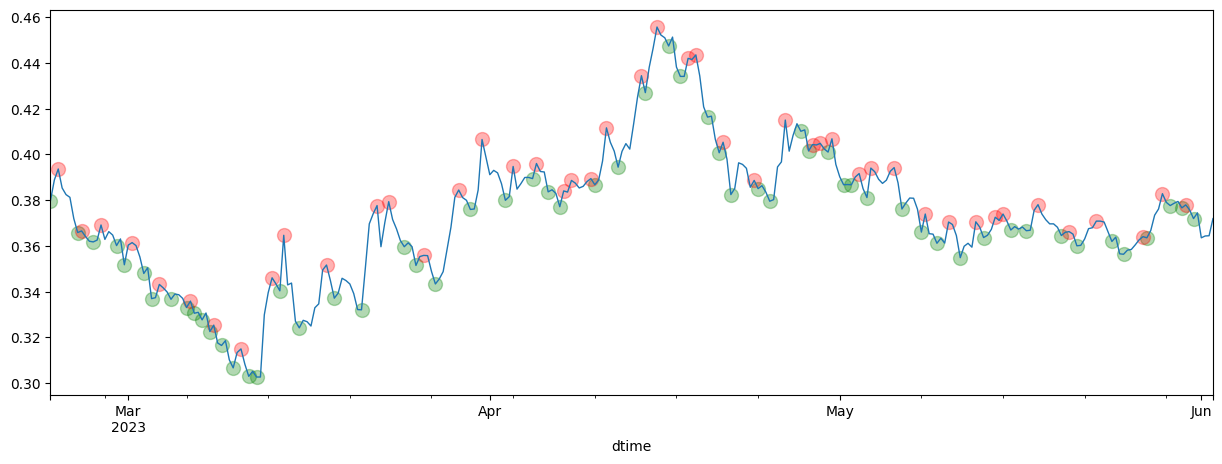

In [208]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.subplots(1,1)
gdf = wdf.iloc[-300:]
gdf.close.plot(ax=ax1)
gix_mins = [ix for ix in ix_mins if ix in gdf.index]
gix_maxs = [ix for ix in ix_maxs if ix in gdf.index]
# gix_maxs = ix_maxs[gdf.index]
# gdf.close.ewm(50).mean().plot(ax=ax1)
# gdf.close.ewm(120).mean().plot(ax=ax1)
# gdf.c_xmax_3.plot(lw=0.5)

ax1.scatter(gix_mins, gdf.loc[gix_mins].close, c='g', alpha=0.3, s=100)
ax1.scatter(gix_maxs, gdf.loc[gix_maxs].close, c='r', alpha=0.3, s=100)

In [209]:
wdf.columns.values

array(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'iord',
       'lret', 'bo_low', 'bo_high', 'bo_range', 'ca_range', 'ca_wickD',
       'ca_wickH', 'ca_dir', 'la_1_lret', 'la_2_lret', 'la_3_lret',
       'la_4_lret', 'la_5_lret', 'la_1_bo_low', 'la_2_bo_low',
       'la_3_bo_low', 'la_4_bo_low', 'la_5_bo_low', 'la_1_bo_high',
       'la_2_bo_high', 'la_3_bo_high', 'la_4_bo_high', 'la_5_bo_high',
       'la_1_bo_range', 'la_2_bo_range', 'la_3_bo_range', 'la_4_bo_range',
       'la_5_bo_range', 'la_1_ca_range', 'la_2_ca_range', 'la_3_ca_range',
       'la_4_ca_range', 'la_5_ca_range', 'la_1_ca_wickD', 'la_2_ca_wickD',
       'la_3_ca_wickD', 'la_4_ca_wickD', 'la_5_ca_wickD', 'la_1_ca_wickH',
       'la_2_ca_wickH', 'la_3_ca_wickH', 'la_4_ca_wickH', 'la_5_ca_wickH',
       'ema_14', 'cema_ret_14', 'std_14', 'ema_21', 'cema_ret_21',
       'std_21', 'ema_26', 'cema_ret_26', 'std_26', 'ema_50',
       'cema_ret_50', 'std_50', 'ema_120', 'cema_ret_120', 'std_120',
       'ema_24

## PCA

In [210]:
import re
features = [c for c in wdf.columns.values if not re.match(r'la_\d+_(bo|ca)', c) and not re.match(r'^la_.*lret$', c)]
features

['timestamp',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'iord',
 'lret',
 'bo_low',
 'bo_high',
 'bo_range',
 'ca_range',
 'ca_wickD',
 'ca_wickH',
 'ca_dir',
 'ema_14',
 'cema_ret_14',
 'std_14',
 'ema_21',
 'cema_ret_21',
 'std_21',
 'ema_26',
 'cema_ret_26',
 'std_26',
 'ema_50',
 'cema_ret_50',
 'std_50',
 'ema_120',
 'cema_ret_120',
 'std_120',
 'ema_240',
 'cema_ret_240',
 'std_240',
 'ema_ret_14_21',
 'ema_ret_14_26',
 'ema_ret_14_50',
 'ema_ret_14_120',
 'ema_ret_14_240',
 'ema_ret_21_26',
 'ema_ret_21_50',
 'ema_ret_21_120',
 'ema_ret_21_240',
 'ema_ret_26_50',
 'ema_ret_26_120',
 'ema_ret_26_240',
 'ema_ret_50_120',
 'ema_ret_50_240',
 'ema_ret_120_240',
 'n_prev',
 'laMean',
 'laMin',
 'laMax',
 'laStd',
 'laZScore',
 'wd2laMeanP',
 'wdSum',
 'wdMin',
 'iword',
 'imins_0',
 'imins_1',
 'imins_2',
 'imins_3',
 'imins_4',
 'imins_5',
 'imaxs_0',
 'imaxs_1',
 'imaxs_2',
 'imaxs_3',
 'imaxs_4',
 'imaxs_5',
 'cmins_0',
 'cret_mins_0',
 'cmaxs_0',
 'cret_maxs_0',
 'cmins_1',

(1000, 189) (1000, 2)


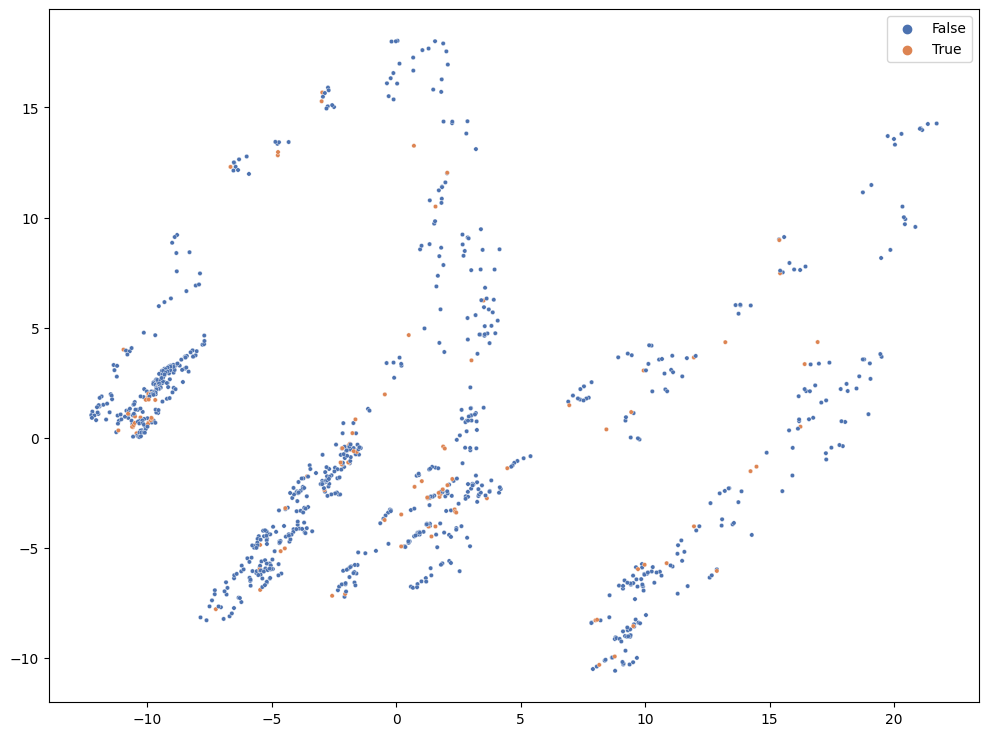

In [211]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer

wstart = wdf.shape[0] // 2
wlen = 1000
wend = min(wdf.shape[0], wstart + wlen)
adf = wdf.dropna().iloc[wstart:wend]#[features]

X = adf.values
r2r = 0.5
target_ret = 0.025
sl_ret = - target_ret * r2r
timeout = 6
# fu_rets = adf.lret.rolling(timeout).sum().fillna(0).round(3)
fu_dds = adf.low.rolling(timeout).min().shift(-timeout).divide(adf.close).apply(np.log).fillna(0).round(3)
fu_rets = adf.high.rolling(timeout).max().shift(-timeout).divide(adf.close).apply(np.log).fillna(0).round(3)
# fu_rets
# qs = np.quantile(fu_rets, np.linspace(0,1,6))
# y_cut, y_bins = pd.qcut(fu_rets, np.linspace(0,1,8), retbins=True)
# y = y_cut.map(lambda x: x.right).astype(float).values 
y = (
        (fu_rets >= target_ret) & (fu_dds >= sl_ret)
     ).fillna(False)


# Before applying PCA, each feature should be centered (zero mean) and with unit variance
X_normalized = StandardScaler().fit(X).transform(X)  

pca = PCA(n_components = 2).fit(X_normalized)

X_pca = pca.transform(X_normalized)
print(X.shape, X_pca.shape)

fig, ax = plt.subplots(1,1, figsize=(12,9))
ax = sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],hue=y, sizes=0.7,
                         palette='deep',legend='full', s=10)


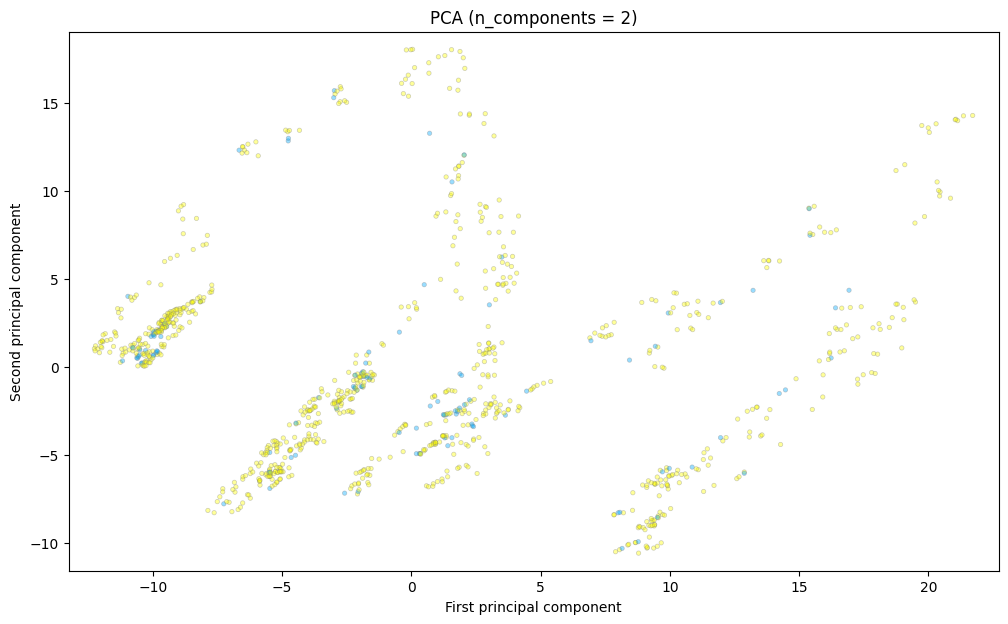

In [212]:
from adspy_shared_utilities import plot_labelled_scatter

fig = plt.figure(figsize=(12,7))
ax = fig.subplots(1,1)
plot_labelled_scatter(X_pca, y, ['True', 'False'], ax=ax)

plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA (n_components = 2)');

#### Plotting the magnitude of each feature value for the first two principal components

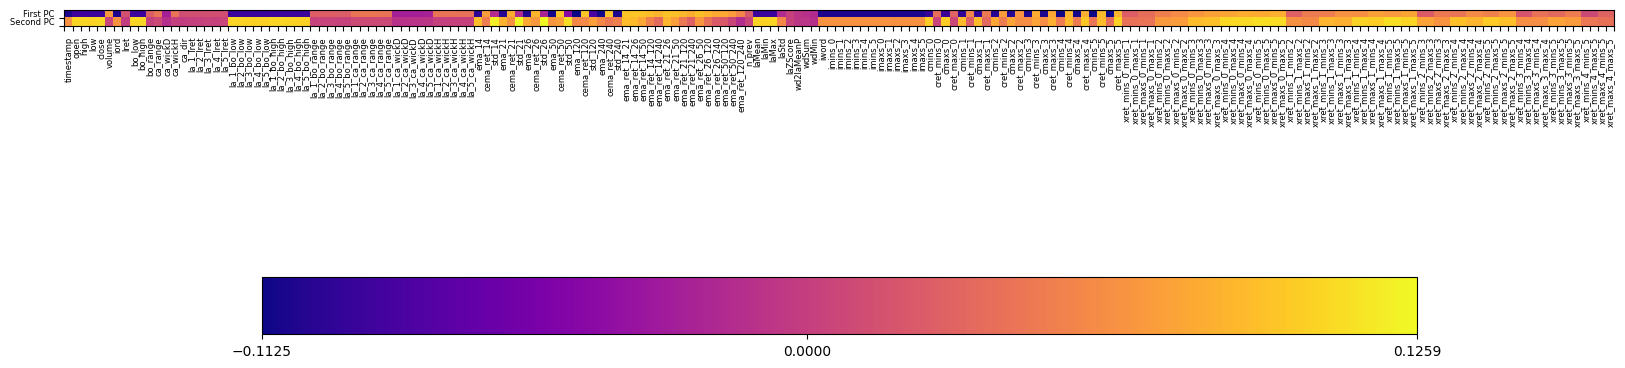

In [213]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(adf.columns)

plt.gca().set_xticks(np.arange(-.5, len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names+[""], rotation=90, ha='left', fontsize=6);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=6); 

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()], pad=0.65);

### Manifold learning methods

#### Multidimensional scaling (MDS) 

In [125]:
# pd.cut(adf.lret.rolling(timeout).sum().fillna(0).mul(1000).round(), bins=10)
fu_rets = adf.lret.rolling(timeout).sum().fillna(0)#.mul(1000).round().astype(int)
# fu_rets
# qs = np.quantile(fu_rets, np.linspace(0,1,6))
# qs
# pd.cut(fu_rets, qs).map(lambda x:x.right).astype(float).multiply(100).describe()
# pd.cut(fu_rets, qs).astype(str).values
y_cut, bins = pd.qcut(fu_rets, np.linspace(0,1,8), retbins=True)
# y_cut.map(lambda x: x.right).values, bins
y = y_cut.map(lambda x: x.right).values
bin_counts = y.value_counts()

bin_counts.index.values.astype(float)

array([-0.0131  , -0.00438 ,  0.000333,  0.00537 ,  0.0119  ,  0.0237  ,
        0.0971  ])

/home/grenada/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


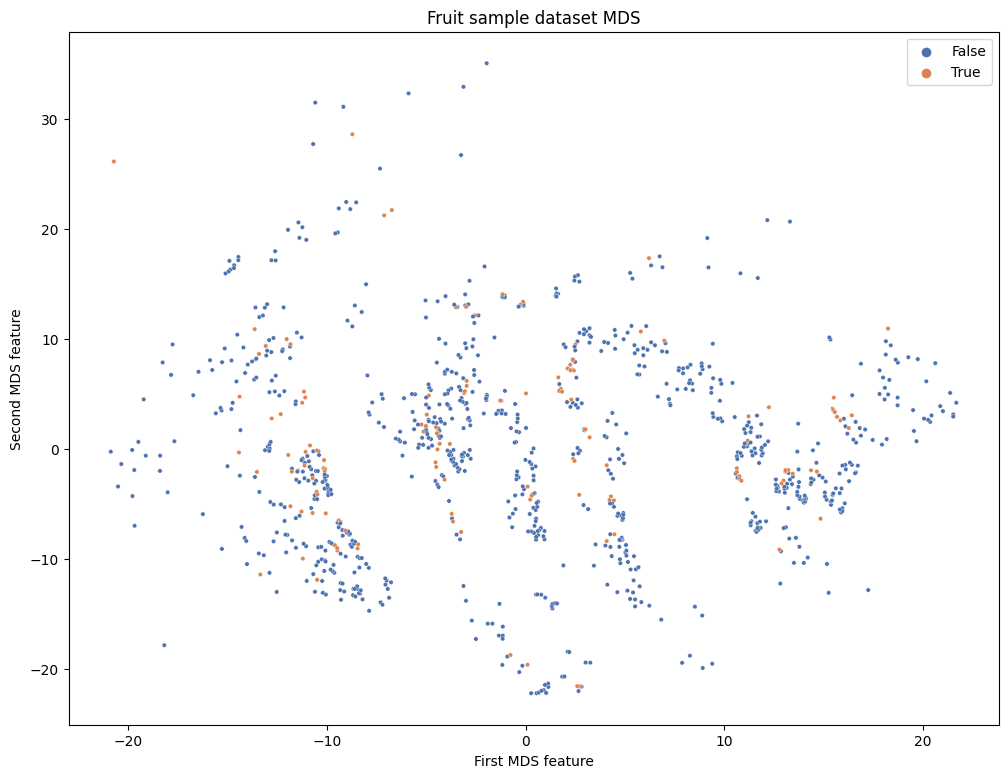

In [221]:
from adspy_shared_utilities import plot_labelled_scatter
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

wstart = wdf.shape[0] // 3 * 2
wlen = 1000
wend = min(wdf.shape[0], wstart + wlen)
adf = wdf.iloc[wstart:wend]#[features]

X = adf.values
r2r = 0.6
target_ret = 0.02
sl_ret = - target_ret * r2r
timeout = 6
# fu_rets = adf.lret.rolling(timeout).sum().fillna(0).round(3)
fu_dds = adf.low.rolling(timeout).min().shift(-timeout).divide(adf.close).apply(np.log).fillna(0).round(3)
fu_rets = adf.high.rolling(timeout).max().shift(-timeout).divide(adf.close).apply(np.log).fillna(0).round(3)
# fu_rets
# qs = np.quantile(fu_rets, np.linspace(0,1,6))
# y_cut, y_bins = pd.qcut(fu_rets, np.linspace(0,1,8), retbins=True)
# y = y_cut.map(lambda x: x.right).astype(float).values 
y = (
        (fu_rets >= target_ret) & (fu_dds >= sl_ret)
     ).fillna(False)
# fu_rets
# qs = np.quantile(fu_rets, np.linspace(0,1,6))
# y_cut, y_bins = pd.qcut(fu_rets, np.linspace(0,1,11), retbins=True)
# y = y_cut.map(lambda x: x.right).astype(float).values 


# y = (adf.close.rolling(timeout).max().shift(-timeout).divide(adf.close).apply(np.log) >= target_ret ).fillna(False)

# each feature should be centered (zero mean) and with unit variance
X_normalized = StandardScaler().fit(X).transform(X)  

mds = MDS(n_components = 2)

X_mds = mds.fit_transform(X_normalized)

# plot_labelled_scatter(X_mds, y, bin_counts.index.values.astype(float), figsize=(12,7))
fig, ax = plt.subplots(1,1, figsize=(12,9))
ax = sns.scatterplot(x=X_mds[:, 0], y=X_mds[:, 1],hue=y, sizes=0.7,
                         palette='deep',legend='full', s=10)

plt.xlabel('First MDS feature')
plt.ylabel('Second MDS feature')
plt.title('Fruit sample dataset MDS');

## t-SNE

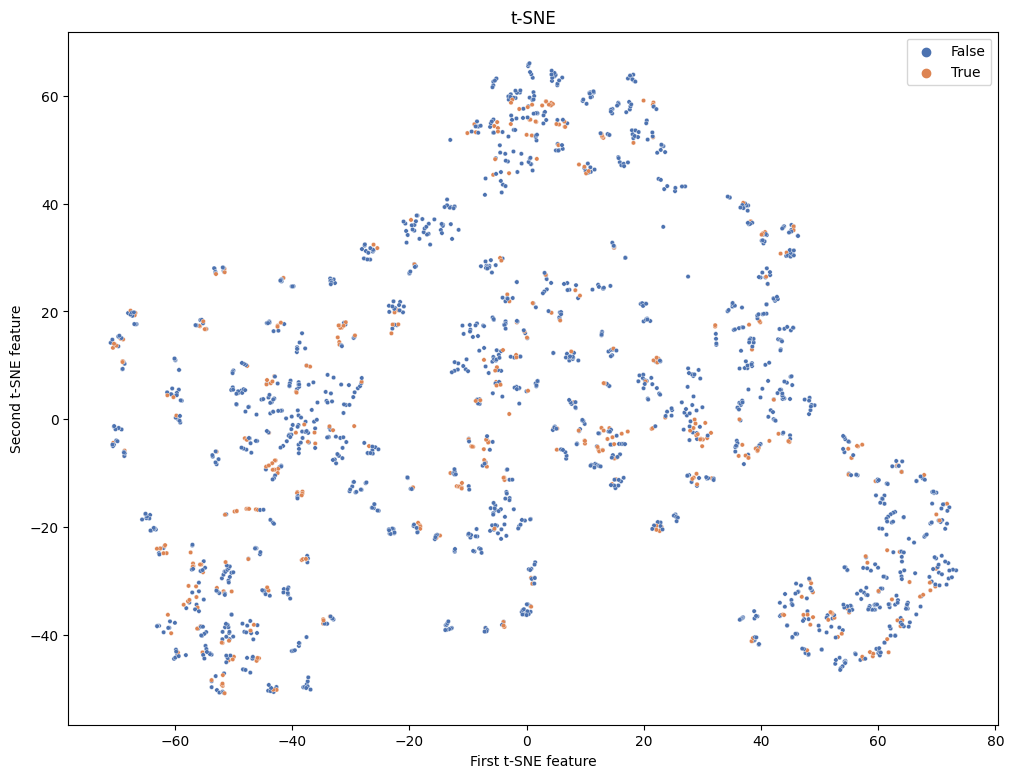

In [220]:
from sklearn.manifold import TSNE

wstart = wdf.shape[0] //  2
wlen = 2000
wend = min(wdf.shape[0], wstart + wlen)
adf = wdf.iloc[wstart:wend]#[features]

X = adf.values
r2r = 0.7
target_ret = 0.03
sl_ret = - target_ret * r2r
timeout = 6
# fu_rets = adf.lret.rolling(timeout).sum().fillna(0).round(3)
fu_dds = adf.low.rolling(timeout).min().shift(-timeout).divide(adf.close).apply(np.log).fillna(0).round(3)
fu_rets = adf.high.rolling(timeout).max().shift(-timeout).divide(adf.close).apply(np.log).fillna(0).round(3)
# fu_rets
# qs = np.quantile(fu_rets, np.linspace(0,1,6))
# y_cut, y_bins = pd.qcut(fu_rets, np.linspace(0,1,8), retbins=True)
# y = y_cut.map(lambda x: x.right).astype(float).values 
y = (
        (fu_rets >= target_ret) & (fu_dds >= sl_ret)
     ).fillna(False)
tsne = TSNE(random_state = 0, n_jobs=8, method='exact')

# each feature should be centered (zero mean) and with unit variance
X_normalized = StandardScaler().fit(X).transform(X)  
X_tsne = tsne.fit_transform(X_normalized)

fig, ax = plt.subplots(1,1, figsize=(12,9))
ax = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1],hue=y,
                         palette='deep',legend='full', s=10)


# plot_labelled_scatter(X_tsne, y, 
#     ['True', 'mandarin', 'orange', 'lemon'])
plt.xlabel('First t-SNE feature')
plt.ylabel('Second t-SNE feature')
plt.title('t-SNE');

### Gradient Boosted Decision Tree

In [ ]:
### Gradient Boosted Decision Tree

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# [wdf.cret_maxs_2 >= 0.01]
adf = wdf.dropna()
X_wdf = adf.values
# y_wdf = (adf.ca_dir.shift(-1).ffill() == 1).values

# y_wdf = (adf.high.rolling(3).max().shift(-3) >= adf.cmaxs_2).fillna(False)
y_wdf = (adf.lret.rolling(3).sum().shift(-3) >= 0.02).fillna(False)

X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0)

scaler = MinMaxScaler()

X_trainS = scaler.fit_transform(X_train)
X_testS = scaler.transform(X_test)

Lrs = [0.005, 0.01, 0.1, ]
Mds = [4,5,7,10]

# Lrs = [0.005, 0.1]
# Mds = [2,3,]
lenX = len(Lrs); lenY=len(Mds);
fig, axs = plt.subplots(lenX, lenY, figsize=(20,20))
plt.tight_layout(h_pad=4, w_pad=2)
for ix in range(lenX):
     for iy in range(lenY):
          learning_rate = Lrs[ix]
          max_depth = Mds[iy]

          m = GradientBoostingClassifier(learning_rate = learning_rate, max_depth = max_depth, random_state = 0)
          m.fit(X_train, y_train)

          y_scores_lr = m.decision_function(X_testS)
          precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
          y_pred_train =  m.predict(X_trainS)
          y_pred_test =  m.predict(X_testS)

          accuracy_train = accuracy_score(y_train,y_pred_train)
          accuracy_test = accuracy_score(y_test, y_pred_test)
          precision_train = precision_score(y_train, y_pred_train)
          precision_test = precision_score(y_test, y_pred_test)
          recall_train = recall_score(y_train, y_pred_train)
          recall_test = recall_score(y_test, y_pred_test)
          # print(precision)
          print('=========================================================')

          print(f'(learning_rate={learning_rate}, max_depth={max_depth})')
          # print(f'-------\tClassification Report - TRAIN\t -------')
          # print(classification_report(y_train, y_pred_train, target_names=['False', 'True']))
          # print(f'-------\tClassification Report - TEST\t -------')
          # print(classification_report(y_test, y_pred_test, target_names=['False', 'True']))
          print(f'\t\tAcc(train)={accuracy_train:.2f}\tAcc(test)={accuracy_test:.2f}')
          print(f'\t\tPrecision(Train)={precision_train:.2f}\tRecall(Train)={recall_train:.2f}')
          print(f'\t\tPrecision(Test)={precision_test:.2f}\tRecall(Test)={recall_test:.2f}')
          ax = axs[ix, iy]
          ax.set_title(f'LR={learning_rate}, MDepth={max_depth}, acc(train)={round(accuracy_train,2)}, \nacc(test)={round(accuracy_test,2)}')
          ax.set_aspect('equal')
          ax.set_xlim([0.0, 1.01])
          ax.set_ylim([0.0, 1.01])
          ax.plot(precision, recall, label='Precision-Recall Curve')
          # plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
          ax.set_xlabel('Precision')
          ax.set_ylabel('Recall')
          ax.grid()

In [ ]:
adf

### Neural Networks

In [ ]:
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

def fit_neural_net(layers, units, X_train, y_train, X_test, y_test):
    print(''.join(['=']*100))
    print(f'Neural net classifier, {wdf.shape[1]} features, {layers} layer, {units} units')

    m = MLPClassifier(hidden_layer_sizes = [units]* layers, solver='lbfgs',
                        random_state = 0).fit(X_train, y_train)
    
    # y_scores_lr = m.decision_function(X_testS)
    # precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
    
    # train_score = m.score(X_trainS, y_train)
    # test_score  = m.score(X_testS, y_test)


    y_pred_train =  m.predict(X_train)
    y_pred_test =  m.predict(X_test)

    accuracy_train = accuracy_score(y_train,y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    report = classification_report(y_test, y_pred_test, target_names=['False', 'True'])
    # print(f'(learning_rate={learning_rate}, max_depth={max_depth})')
    # print(f'-------\tClassification Report - TRAIN\t -------')
    # print(classification_report(y_train, y_pred_train, target_names=['False', 'True']))
    # print(f'-------\tClassification Report - TEST\t -------')
    print(f'Acc(train)={accuracy_train:.2f}\tAcc(test)={accuracy_test:.2f}')
    print(f'Precision(Train)={precision_train:.2f}\tRecall(Train)={recall_train:.2f}')
    print(f'Precision(Test)={precision_test:.2f}\tRecall(Test)={recall_test:.2f}')
    # print(f''.join(['-']*70))
    print(f'----------- Classification Report: ------------')
    print(report)

        # print(f"Train score = {train_score:.2f}, Test score = {test_score:.2f}")
        
    # plot_class_regions_for_classifier_subplot(nnclf, X_trainS, y_train,
                                            #  X_testS, y_test, title, axis)
    # plt.tight_layout()
    return m, accuracy_train, accuracy_test, precision_train, precision_test, recall_train, recall_test, report

In [ ]:
### Neural Nets
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot


adf = wdf.dropna()
X_wdf = adf.values
# y_wdf = adf.ca_dir.shift(-1).ffill().values
target_ret = 0.02
r2r = 0.5
timeout = 3
fu_max = adf.high.rolling(timeout).max().shift(-timeout).divide(adf.close).apply(np.log)
fu_min = adf.low.rolling(timeout).min().shift(-timeout).divide(adf.close).apply(np.log)
fu_r2r = fu_min / fu_max
y_wdf = (
    # adf.lret.rolling(3).sum().shift(-3) >= 0.03
    (fu_max >= target_ret) & 
    # (fu_r2r < 0.5)
    (fu_min > - r2r * target_ret)
).fillna(False).astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0, train_size=0.5)

# scaler = MinMaxScaler()
# scaler = preprocessing.StandardScaler().fit(X_train)
scaler = preprocessing.MaxAbsScaler().fit(X_train)

# X_trainS = scaler.fit_transform(X_train)
# X_testS = scaler.transform(X_test)
X_trainS = scaler.transform(X_train)
X_testS = scaler.transform(X_test)


for layers in [2,3,4]:
    for units in [wdf.shape[1] //4, wdf.shape[1] // 3, wdf.shape[1] //2, wdf.shape[1]]:
        m, accuracy_train, accuracy_test, precision_train, precision_test, recall_train, recall_test, report = (
            fit_neural_net(layers, units, X_train, y_train, X_test, y_test)
        )

#### Manually create the best model

In [ ]:
layers, units = 4, adf.shape[1]
m, accuracy_train, accuracy_test, precision_train, precision_test, recall_train, recall_test, report = (
            fit_neural_net(layers, units, X_train, y_train, X_test, y_test)
        )


#### Backtest the results

### K-Nearest Neighbour

In [ ]:
### KNN


adf = wdf.dropna()
X_wdf = adf.values
# y_wdf = adf.ca_dir.shift(-1).ffill().values

target_ret = 0.015
r2r = 0.4
timeout = 3
fu_max = adf.high.rolling(timeout).max().shift(-timeout).divide(adf.close).apply(np.log)
fu_min = adf.low.rolling(timeout).min().shift(-timeout).divide(adf.close).apply(np.log)
fu_r2r = - fu_min / fu_max

y_wdf = (
    (fu_max >= target_ret) &
    (fu_r2r < r2r)
).fillna(False).astype(int).values

X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0)

# scaler = MinMaxScaler()
scaler = preprocessing.MaxAbsScaler().fit(X_train)

# X_trainS = scaler.fit_transform(X_train)
# X_testS = scaler.transform(X_test)
X_trainS = X_train
X_testS = X_test

# Instantiate KNN learning model(k=15)
aneighbours = [5,10, 20,30]
algos = ['auto', 'ball_tree', 'kd_tree', 'brute']
for neighbours in aneighbours:
    for algo in algos:
        print(''.join(['='* 80]))
        print(f'=== K-Nearest Neighbours algo="{algo}"; n_neighbors={neighbours}')
        knn = KNeighborsClassifier(n_neighbors=neighbours, n_jobs=4, algorithm=algo )

        # fit the model
        m = knn.fit(X_trainS, y_train)

        # # Accuracy Score
        # accuracy_train = accuracy_score(y_train, knn.predict(X_trainS))
        # accuracy_test = accuracy_score(y_test, knn.predict(X_testS))

        y_pred_train =  m.predict(X_trainS)
        y_pred_test =  m.predict(X_testS)

        accuracy_train = accuracy_score(y_train,y_pred_train)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        precision_train = precision_score(y_train, y_pred_train)
        precision_test = precision_score(y_test, y_pred_test)
        recall_train = recall_score(y_train, y_pred_train)
        recall_test = recall_score(y_test, y_pred_test)
        report = classification_report(y_test, y_pred_test, target_names=['False', 'True'])
        print(f'Acc(train)={accuracy_train:.2f}\tAcc(test)={accuracy_test:.2f}')
        print(f'Precision(Train)={precision_train:.2f}\tRecall(Train)={recall_train:.2f}')
        print(f'Precision(Test)={precision_test:.2f}\tRecall(Test)={recall_test:.2f}')
        print(f'----------- Classification Report: ------------')
        print(report)

In [ ]:

# adf = wdf.dropna()
# X_wdf = adf.values
# y_wdf = adf.ca_dir.shift(-1).ffill().values

# target_ret = 0.03
# r2r = 0.5
# timeout = 3
# fu_max = adf.high.rolling(timeout).max().shift(-timeout).divide(adf.close).apply(np.log)
# fu_min = adf.low.rolling(timeout).min().shift(-timeout).divide(adf.close).apply(np.log)
# fu_r2r = - fu_min / fu_max

# y_wdf = (
#     (fu_max >= target_ret) &
#     (fu_r2r < r2r)
# ).fillna(False).astype(int).values

# X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0)

# scaler = MinMaxScaler()
# scaler = preprocessing.MaxAbsScaler().fit(X_train)

# X_trainS = scaler.fit_transform(X_train)
# X_testS = scaler.transform(X_test)
# X_trainS = X_train
# X_testS = X_test

algo="auto"; n_neighbors=5
knn = KNeighborsClassifier(n_neighbors=neighbours, n_jobs=4, algorithm=algo )

# fit the model
m = knn.fit(X_trainS, y_train)

# # Accuracy Score
# accuracy_train = accuracy_score(y_train, knn.predict(X_trainS))
# accuracy_test = accuracy_score(y_test, knn.predict(X_testS))

y_pred_train =  m.predict(X_trainS)
y_pred_test =  m.predict(X_testS)

report = classification_report(y_test, y_pred_test, target_names=['False', 'True'])
print(f'----------- Classification Report: ------------')
print(report)
y_pred_test.sum()

In [ ]:
## Backtest

# [['open', 'high', 'low', 'close', 'lret']]
r2r = 0.5
tdf = adf.iloc[X_train.shape[0]:].copy()
timeout_ret = tdf.close.shift(-timeout).divide(tdf.close).apply(np.log).fillna(0)
sl_ret = - r2r * target_ret
# tdf.shape, y_pred_test.shape
# # tdf = X_test.copy()
fu_min_ret = tdf.low.rolling(timeout).min().shift(-timeout).divide(tdf.close).apply(np.log)
sl_hit = (fu_min_ret < sl_ret ).fillna(False)
fu_max_ret = tdf.high.rolling(timeout).max().shift(-timeout).divide(tdf.close).apply(np.log) 
target_hit = (fu_max_ret > target_ret).fillna(False)
rets = np.where(y_pred_test, 
    np.where(sl_hit, sl_ret, 
        np.where(target_hit, target_ret, timeout_ret)
    )
, 0)

tdf['y_pred'] = y_pred_test
tdf['pnl'] = rets
tdf['cumpnl'] = rets.cumsum()
# cum_rets = rets.cumsum()
# sl_hit.shape, tdf.shape, fu_min_ret.shape
# y_pred_test.shape, y_pred_test.sum()
sl_hit.sum(), target_hit.sum(), tdf['cumpnl'][-1]

In [ ]:
y_pred_test.sum()

In [ ]:
tdf[tdf.pnl >= target_ret ]['pnl'].shape

In [ ]:

fig = plt.figure(figsize=(15,5))
ax1, ax2 = fig.subplots(2,1, sharex=True, height_ratios=[2,1])
tdf.close.plot(ax=ax1, secondary_y=False)
tdf.cumpnl.plot(ax=ax1, secondary_y=True)
# for ix in tdf.iloc[y_pred_test].index :
#     ax1.axvline(ix)



In [ ]:
### SVC
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve

adf = wdf.dropna()
X_wdf = adf.values
# y_wdf = adf.ca_dir.shift(-1).ffill().values

# y_wdf = (adf.lret.rolling(6).sum().shift(-6) > 0.02).fillna(False).values

target_ret = 0.02
r2r = 0.6
timeout = 3
fu_max = adf.high.rolling(timeout).max().shift(-timeout).divide(adf.close).apply(np.log)
fu_min = adf.low.rolling(timeout).min().shift(-timeout).divide(adf.close).apply(np.log)
fu_r2r = - fu_min / fu_max

y_wdf = (
    (fu_max >= target_ret) &
    (fu_r2r < r2r)
).fillna(False).astype(int).values


X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0)

scaler = MinMaxScaler()
X_trainS = scaler.fit_transform(X_train)
X_testS = scaler.transform(X_test)

gammas = [0.005, 0.01, 1, 5]
Cs = [0.1, 1, 15, 250, 500]
fig, axs = plt.subplots(len(gammas), len(Cs), figsize=(20,20))
plt.tight_layout()

# plt.figure(figsize=(4 * len(gammas),4*len(Cs)))
for igamma in range(len(gammas)):
    for iC in range(len(Cs)):
        gamma = gammas[igamma]
        C = Cs[iC]
        m = SVC(kernel = 'rbf', gamma = gamma,
                 C = C).fit(X_trainS, y_train)
        

        y_scores_lr = m.decision_function(X_testS)
        precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)


        y_pred_train =  m.predict(X_trainS)
        y_pred_test =  m.predict(X_testS)

        accuracy_train = accuracy_score(y_train,y_pred_train)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        precision_train = precision_score(y_train, y_pred_train)
        precision_test = precision_score(y_test, y_pred_test)
        recall_train = recall_score(y_train, y_pred_train)
        recall_test = recall_score(y_test, y_pred_test)
        report = classification_report(y_test, y_pred_test, target_names=['False', 'True'])
        print(f'Acc(train)={accuracy_train:.2f}\tAcc(test)={accuracy_test:.2f}')
        print(f'Precision(Train)={precision_train:.2f}\tRecall(Train)={recall_train:.2f}')
        print(f'Precision(Test)={precision_test:.2f}\tRecall(Test)={recall_test:.2f}')
        print(f'----------- Classification Report: ------------')
        print(report)


        ax = axs[igamma, iC]
        ax.set_title(f'gamma={gamma}, C={C}, acc(train)={round(accuracy_train,2)}, \nacc(test)={round(accuracy_test,2)}')
        ax.set_aspect('equal')
        ax.set_xlim([0.0, 1.01])
        ax.set_ylim([0.0, 1.01])
        ax.plot(precision, recall, label='Precision-Recall Curve')
        # plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
        ax.set_xlabel('Precision', fontsize=16)
        ax.set_ylabel('Recall', fontsize=16)
        ax.grid()
        # plt.show()

In [ ]:
len(wdf.columns)